# Vorhersage eines Triebwerksausfalls aufgrund von Sensormesswerten

In [1]:
import h5py
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filename = '../data/N-CMAPSS_DS03-012.h5'

In [3]:
# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # Sensors
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # Sensors
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))

In [16]:
df_A = DataFrame(data=A_dev, columns=A_var)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_A.describe()


,unit,cycle,Fc,hs
count,5.571277e+06,5.571277e+06,5.571277e+06,5.571277e+06
mean,5.382994e+00,3.637726e+01,2.170105e+00,3.319295e-01
std,2.399958e+00,2.157529e+01,7.257075e-01,4.709059e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,1.800000e+01,2.000000e+00,0.000000e+00
50%,6.000000e+00,3.600000e+01,2.000000e+00,0.000000e+00
75%,8.000000e+00,5.400000e+01,3.000000e+00,1.000000e+00
max,9.000000e+00,9.300000e+01,3.000000e+00,1.000000e+00


### Unit Ids 
Mit diesem Codeabschnitt wird geschaut wie viele Triebwerke im Devset und im Testset sind.

In [17]:
print(np.unique(df_A["unit"]))
print(np.unique(df_A_test["unit"]))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[10. 11. 12. 13. 14. 15.]


## Datenaufbereitung

In [4]:
# Train
fc = A_dev[:, 0].reshape(-1, 1)
X_dev = X_s_dev[:, [1, 2, 3, 8, 9, 12, 13]]
X_train = np.concatenate((X_dev, fc), axis=1)
Y_train = Y_dev.ravel()

# Test
fc_test = A_test[:, 0].reshape(-1, 1)
X_test = X_s_test[:, [1, 2, 3, 8, 9, 12, 13]]
X_test = np.concatenate((X_test, fc_test), axis=1)
Y_test = Y_test.ravel()

## XGBoost

In [5]:
# Import
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error

In [6]:
feature_names = (["T30", "T48", "T50", "Ps30", "P40", "Nc", "Wf"] + ["fc"])
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=Y_test, feature_names=feature_names)

### Model Training

In [ ]:
# Training parameters
params = {
    "objective": "reg:squarederror",   # regression
    "max_depth": 5,                    # tree depth
    "eta": 0.05,                       # learning rate
    "subsample": 0.8,                  # row sampling
    "colsample_bytree": 0.8,           # feature
    "gamma": 0.1,                      # require improvement to split 
    "tree_method": "hist",             # use GPU for training
    "device": "cuda",                  # use GPU
    "seed": 42
}

# Train model
num_round = 570
evallist = [(dtrain, "train"), (dtest, "eval")]

bst = xgb.train(
    params, 
    dtrain, 
    num_round, 
    evals=evallist, 
    #early_stopping_rounds=20,  # stop if no improvement
    verbose_eval=10            # print progress every 10 rounds
)

bst.save_model("../models/xgb_rul_onlyimportantX.json")

[0]	train-rmse:21.37811	eval-rmse:21.15969
[10]	train-rmse:20.21888	eval-rmse:20.19591
[20]	train-rmse:19.32558	eval-rmse:19.63769
[30]	train-rmse:18.76668	eval-rmse:19.38712
[40]	train-rmse:18.15087	eval-rmse:18.93462
[50]	train-rmse:17.52579	eval-rmse:18.35786
[60]	train-rmse:17.07205	eval-rmse:17.98389
[70]	train-rmse:16.65796	eval-rmse:17.60956
[80]	train-rmse:16.25102	eval-rmse:17.29479
[90]	train-rmse:15.88507	eval-rmse:16.97401
[100]	train-rmse:15.56590	eval-rmse:16.72916
[110]	train-rmse:15.23568	eval-rmse:16.42861
[120]	train-rmse:14.97552	eval-rmse:16.21937
[130]	train-rmse:14.74531	eval-rmse:16.04931
[140]	train-rmse:14.50239	eval-rmse:15.85608
[150]	train-rmse:14.23201	eval-rmse:15.61259
[160]	train-rmse:14.07250	eval-rmse:15.48738
[170]	train-rmse:13.87189	eval-rmse:15.31856
[180]	train-rmse:13.69297	eval-rmse:15.15099
[190]	train-rmse:13.56968	eval-rmse:15.04812
[200]	train-rmse:13.44697	eval-rmse:14.95155
[210]	train-rmse:13.31279	eval-rmse:14.85527
[220]	train-rmse:13.1

### Vorhersage

In [7]:
# Load the model
model = xgb.Booster()
model.load_model("../models/xgb_rul_onlyimportantX.json")

# Predict
Y_pred = model.predict(dtest)

### Evaluation

In [8]:
# Evaluation
rmse = root_mean_squared_error(Y_test, Y_pred)
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 13.59


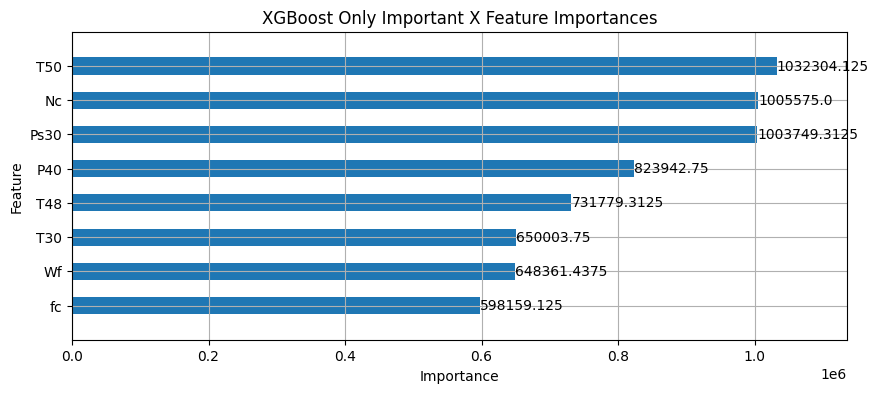

In [9]:
# Feature importances
fig, ax = plt.subplots(figsize=(10, 4))
xgb.plot_importance(model, importance_type="gain", height=0.5, ax=ax)
ax.set_ylabel("Feature")
ax.set_xlabel("Importance")
ax.set_title("XGBoost Only Important X Feature Importances")
plt.show()

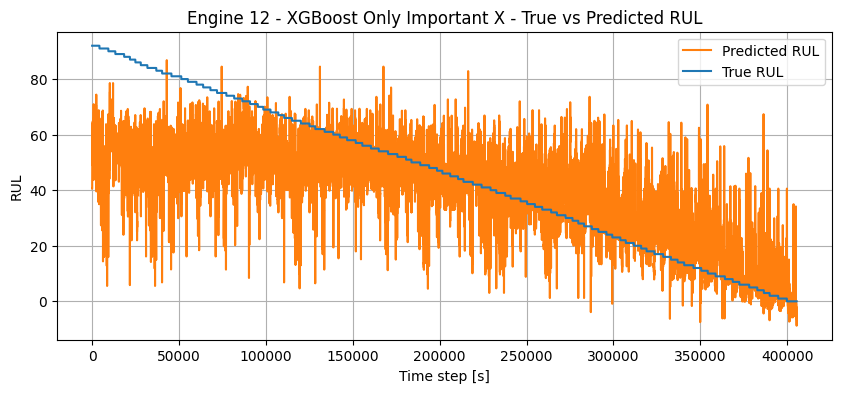

In [10]:
unit_ids_test = A_test[:, 0]
unit = 12
indices = np.where(unit_ids_test == unit)[0]

plt.figure(figsize=(10, 4))
plt.plot(Y_pred[indices], label="Predicted RUL", color='tab:orange')
plt.plot(Y_test[indices], label="True RUL", color='tab:blue')
plt.title(f"Engine {unit} - XGBoost Only Important X - True vs Predicted RUL")
plt.xlabel("Time step [s]")
plt.ylabel("RUL")
plt.legend()
plt.grid(True)
plt.show()